现在我们手头上有三国向中国出口的数据, 尝试预处理这些数据

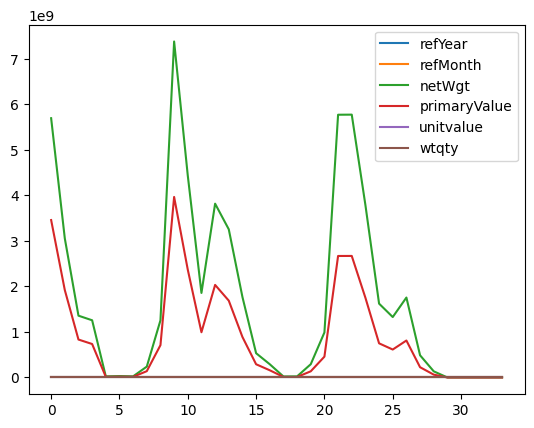

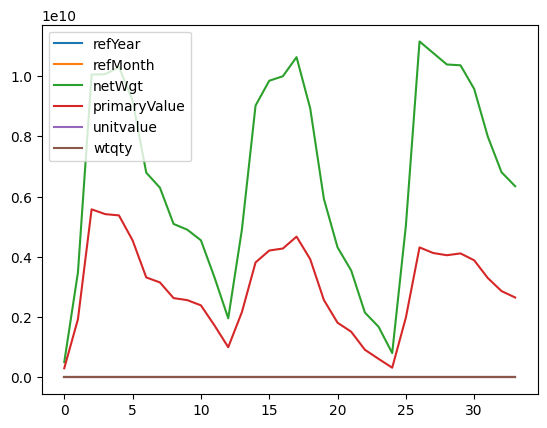

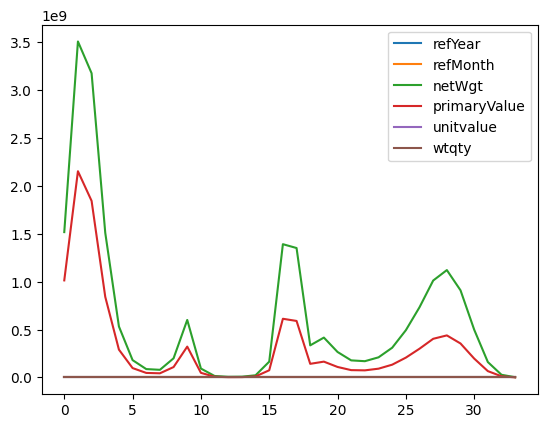

In [2]:
import pandas as pd

# convert excel to csv
df_USA = pd.read_excel(r'..\..\data\raw\Q1_refined\USA.xlsx')
df_USA.head()

# 补充缺失的数据
new_data_row = {
    'refYear': 2025,  # 请手动填写年份，例如 2025
    'refMonth': 0, # 请手动填写月份，例如 1
    'reporterISO': 'USA', # 请手动填写国家ISO代码，例如 'CHN'
    'netWgt': 0,
    'primaryValue': 0,
    'unitvalue': 0,
    'wtqty': 0
}
for i in range(6,11):
    new_data_row['refMonth'] = i
    df_USA = pd.concat([df_USA, pd.DataFrame([new_data_row])], ignore_index=True)

# 展示数据并且简单统计
df_Brazil = pd.read_excel(r'..\..\data\raw\Q1_refined\Brazil.xlsx')
df_Brazil.head()
df_Argentina = pd.read_excel(r'..\..\data\raw\Q1_refined\Argentina.xlsx')
df_Argentina.head()

df_USA.plot()
df_Brazil.plot()
df_Argentina.plot()

df_USA.to_csv(r'..\..\data\processed\Q1.USA.csv', index=False)
df_Brazil.to_csv(r'..\..\data\processed\Q1.Brazil.csv', index=False)
df_Argentina.to_csv(r'..\..\data\processed\Q1.Argentina.csv', index=False)


转化成json格式, 便于echarts作图

In [4]:
# 将三个CSV聚合为页面所需的JSON结构并保存
# 目标结构示例：
# {refMonth: '2024-01', Argentina: <净重kg>, Brazil: <净重kg>, USA: <净重kg>,
#  Argentina_cif: <金额>, Brazil_cif: <金额>, USA_cif: <金额>}

import pandas as pd
import json
from pathlib import Path

# 输入路径
p_arg = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Argentina.csv")
p_bra = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Brazil.csv")
p_usa = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.USA.csv")

# 输出路径
out_json = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.1.soybean_imports_quantity_price.json")

# 辅助函数：读表并统一列
def load_and_norm(path: Path, country_name: str) -> pd.DataFrame:
    # 读取CSV
    df = pd.read_csv(path)
    # 生成统一的月份字符串 YYYY-MM
    # 注意：文件中为 refYear + refMonth（数值型），需格式化为两位月
    df["Month"] = df["refYear"].astype(str) + "-" + df["refMonth"].astype(int).astype(str).str.zfill(2)
    # 选择净重与金额列（与页面一致：净重=netWgt，金额=primaryValue）
    df_norm = df[["Month", "netWgt", "primaryValue"]].copy()
    df_norm["country"] = country_name
    # 按月聚合求和（稳健处理）
    df_norm = df_norm.groupby(["Month", "country"], as_index=False).sum()
    return df_norm

# 分别读取三个国家
df_arg = load_and_norm(p_arg, "Argentina")
df_bra = load_and_norm(p_bra, "Brazil")
df_usa = load_and_norm(p_usa, "USA")

# 合并后透视为宽表：数量与金额分别透视
df_all = pd.concat([df_arg, df_bra, df_usa], ignore_index=True)

# 数量（净重kg）
qty_wide = df_all.pivot(index="Month", columns="country", values="netWgt").fillna(0.0)
# 金额（CIF）
cif_wide = df_all.pivot(index="Month", columns="country", values="primaryValue").fillna(0.0)

# 统一国家列顺序
countries = ["Argentina", "Brazil", "USA"]
qty_wide = qty_wide.reindex(columns=countries).sort_index()
cif_wide = cif_wide.reindex(columns=countries).sort_index()

# 组装为页面所需的JSON数组
records = []
for m in qty_wide.index:
    rec = {"refMonth": m}
    # 数量
    for c in countries:
        rec[c] = float(qty_wide.loc[m, c])
    # 金额
    for c in countries:
        rec[f"{c}_cif"] = float(cif_wide.loc[m, c])
    records.append(rec)

print(records)

# 保存JSON文件（UTF-8，缩进2）
out_json.parent.mkdir(parents=True, exist_ok=True)
with open(out_json, "w", encoding="utf-8") as f:
    json.dump(records, f, ensure_ascii=False, indent=2)

print(f"JSON已保存: {out_json}")
# 如需直接嵌入到HTML的JS代码，可打印：
# print("const data = " + json.dumps(records, ensure_ascii=False))

[{'refMonth': '2023-01', 'Argentina': 1515993282.53599, 'Brazil': 509677600.0, 'USA': 5693521040.0, 'Argentina_cif': 1012395719.0264, 'Brazil_cif': 305875583.0, 'USA_cif': 3456883269.0}, {'refMonth': '2023-02', 'Argentina': 3503981340.02036, 'Brazil': 3483134017.0, 'USA': 3053631893.0, 'Argentina_cif': 2150760688.03151, 'Brazil_cif': 1931031449.0, 'USA_cif': 1919323074.0}, {'refMonth': '2023-03', 'Argentina': 3172557178.85062, 'Brazil': 10042041401.0, 'USA': 1357079848.0, 'Argentina_cif': 1841480521.19693, 'Brazil_cif': 5574663441.0, 'USA_cif': 832884486.0}, {'refMonth': '2023-04', 'Argentina': 1508452358.57944, 'Brazil': 10055168341.0, 'USA': 1256087351.0, 'Argentina_cif': 840830761.283419, 'Brazil_cif': 5416095343.0, 'USA_cif': 735036906.0}, {'refMonth': '2023-05', 'Argentina': 531999999.999999, 'Brazil': 10293020511.0, 'USA': 24564000.0, 'Argentina_cif': 290432631.999999, 'Brazil_cif': 5374180072.0, 'USA_cif': 14380306.0}, {'refMonth': '2023-06', 'Argentina': 181000000.0, 'Brazil': 

接下来我们我们需要来评价影响, 采用熵权法加上topsis

Indicator Weights (Entropy):
total_volume          0.193
total_value           0.187
avg_monthly_volume    0.188
market_share          0.188
avg_unit_price        0.069
stability             0.106
trend_coef            0.070
dtype: float64

Pre-Tariff TOPSIS Scores (2024):
country
Argentina    0.1601
Brazil       0.7809
USA          0.3928
dtype: float64

Post-Tariff TOPSIS Scores (2025):
country
Argentina    0.0863
Brazil       1.0000
USA          0.0056
dtype: float64


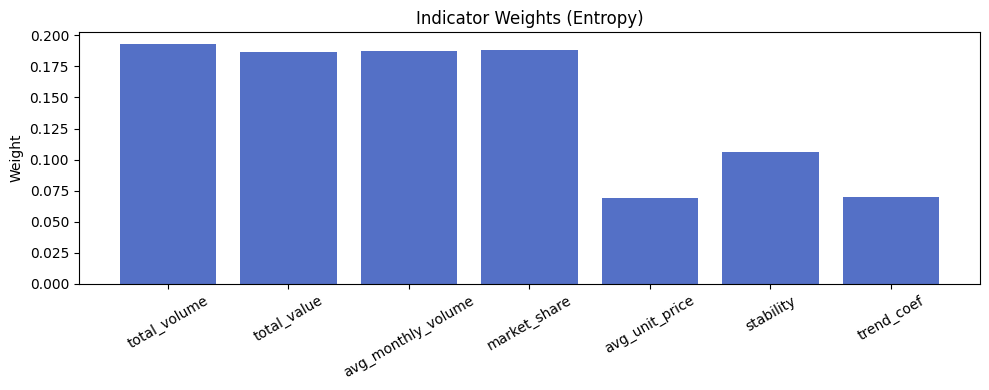

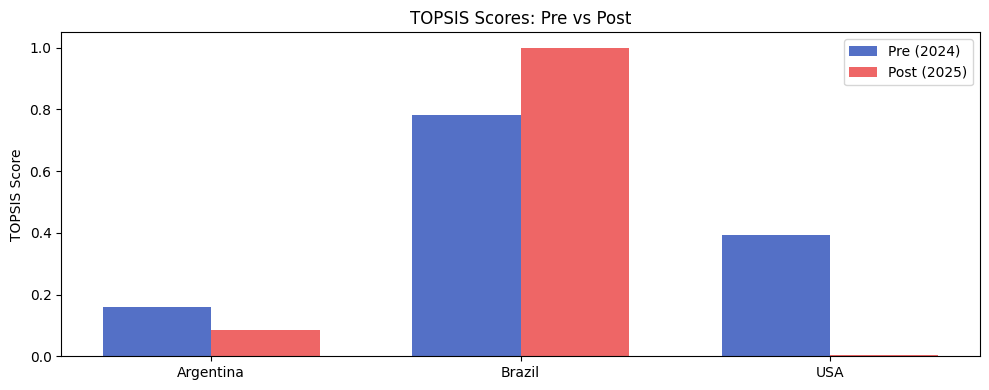

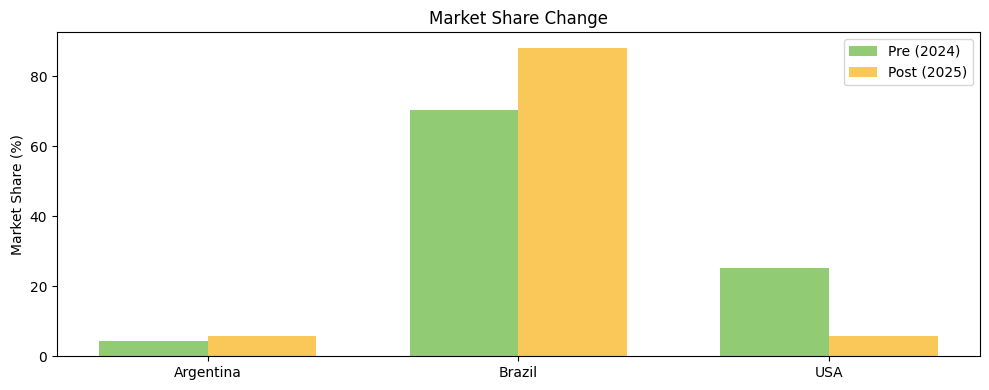

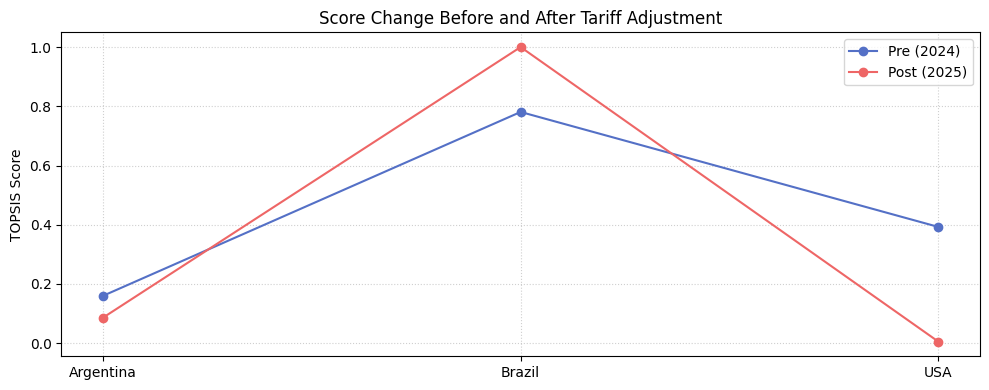

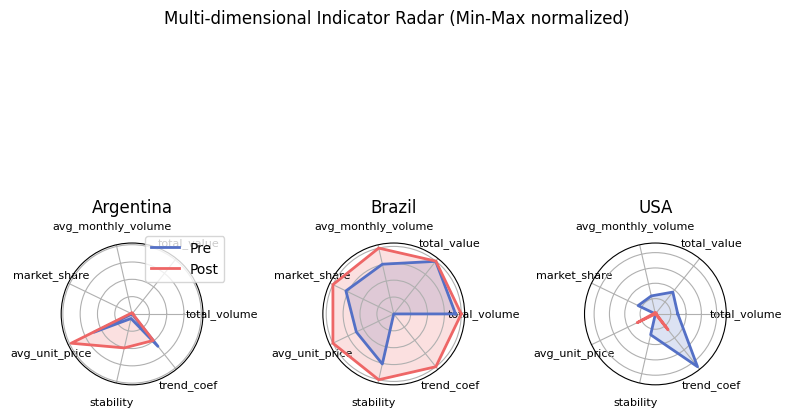

In [7]:
# 目标：基于熵权法+TOPSIS评估三国（阿根廷/巴西/美国）在中国大豆进口中的表现变化
# 数据源：三个CSV（Argentina/Brazil/USA），按月聚合；对比 2024（关税前）与 2025（关税后）
# 指标：total_volume、total_value、avg_monthly_volume、market_share、avg_unit_price（成本型）、stability、trend_coef
# 说明：权重使用熵权法在“合并（2024+2025）”数据上训练；TOPSIS使用加权向量归一化，理想解考虑收益/成本方向
# 绘图：英文标签，非阻塞式

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# 路径设置（按需调整）
p_arg = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Argentina.csv")
p_bra = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Brazil.csv")
p_usa = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.USA.csv")

# 国家名称映射
COUNTRY_ALIAS = {"ARG": "Argentina", "BRA": "Brazil", "USA": "USA"}
COUNTRIES = ["Argentina", "Brazil", "USA"]

# 指标定义
INDICATORS = [
    "total_volume", "total_value", "avg_monthly_volume",
    "market_share", "avg_unit_price", "stability", "trend_coef"
]
COST_INDICATORS = {"avg_unit_price"}  # 成本型指标（值越小越好）

# 读取并规范数据
def load_and_prepare(path: Path, country_code: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    # 生成 YYYY-MM 月份字符串
    df["Month"] = df["refYear"].astype(str) + "-" + df["refMonth"].astype(int).astype(str).str.zfill(2)
    # 统一字段与国家名
    df = df[["Month", "netWgt", "primaryValue"]].copy()
    df["country"] = COUNTRY_ALIAS.get(country_code, country_code)
    return df

df_arg = load_and_prepare(p_arg, "ARG")
df_bra = load_and_prepare(p_bra, "BRA")
df_usa = load_and_prepare(p_usa, "USA")

# 合并与按月聚合（稳健求和）
df_all = pd.concat([df_arg, df_bra, df_usa], ignore_index=True)
df_all = df_all.groupby(["Month", "country"], as_index=False).sum()

# 按时期分割（2024 vs 2025）
pre_df = df_all[df_all["Month"].str.startswith("2024")].copy()
post_df = df_all[df_all["Month"].str.startswith("2025")].copy()

# 计算国家层面的指标
def calculate_metrics(df_period: pd.DataFrame) -> pd.DataFrame:
    # 总市场规模（市占率分母）
    total_market_volume = df_period.groupby("Month")["netWgt"].sum().sum()
    out = []
    for c in COUNTRIES:
        d = df_period[df_period["country"] == c].sort_values("Month")
        vols = d["netWgt"].values.astype(float)
        vals = d["primaryValue"].values.astype(float)
        total_volume = float(vols.sum())
        total_value = float(vals.sum())
        avg_monthly_volume = float(vols.mean()) if len(vols) > 0 else 0.0
        market_share = float((total_volume / total_market_volume) * 100) if total_market_volume > 0 else 0.0
        avg_unit_price = float((total_value / total_volume) * 1000) if total_volume > 0 else 0.0  # USD/ton
        # 稳定性（变异系数CV的反函数）
        cv = float(vols.std(ddof=1) / vols.mean()) if (len(vols) > 1 and vols.mean() != 0) else 0.0
        stability = float(1.0 / (1.0 + cv))
        # 趋势斜率（线性拟合）
        trend_coef = float(np.polyfit(np.arange(len(vols)), vols, 1)[0]) if len(vols) > 1 else 0.0
        out.append({
            "country": c,
            "total_volume": total_volume,
            "total_value": total_value,
            "avg_monthly_volume": avg_monthly_volume,
            "market_share": market_share,
            "avg_unit_price": avg_unit_price,
            "stability": stability,
            "trend_coef": trend_coef,
        })
    return pd.DataFrame(out).set_index("country")

pre_metrics = calculate_metrics(pre_df)
post_metrics = calculate_metrics(post_df)

# 熵权法：在合并（pre+post）数据上训练权重
def entropy_weights(pre: pd.DataFrame, post: pd.DataFrame) -> pd.Series:
    combined = pd.concat([pre, post], axis=0)  # 6行×7列
    norm = pd.DataFrame(index=combined.index, columns=INDICATORS, dtype=float)

    # min-max 归一化（成本型指标反向处理）
    for ind in INDICATORS:
        col = combined[ind].astype(float)
        mn, mx = float(col.min()), float(col.max())
        if mx == mn:
            norm[ind] = 0.5  # 全等时置中
        else:
            if ind in COST_INDICATORS:
                norm[ind] = (mx - col) / (mx - mn)  # 成本型反向
            else:
                norm[ind] = (col - mn) / (mx - mn)  # 效益型正向

    # 计算比例矩阵 p_ij
    p = pd.DataFrame(index=norm.index, columns=INDICATORS, dtype=float)
    for ind in INDICATORS:
        s = float(norm[ind].sum())
        if s == 0.0:
            p[ind] = 1.0 / len(norm)  # 全零时均分
        else:
            p[ind] = norm[ind] / s

    # 信息熵 e_j 与差异度 d_j
    m = len(norm)  # 备选数（6）
    k = 1.0 / np.log(m)
    eps = 1e-12
    e = -k * (p.clip(eps, 1.0).apply(lambda col: (col * np.log(col)).sum()))
    d = 1.0 - e
    w = d / d.sum()
    return w

weights = entropy_weights(pre_metrics, post_metrics)  # pd.Series

# TOPSIS评分（按时期分别计算）
def topsis_scores(metrics: pd.DataFrame, weights: pd.Series) -> pd.Series:
    X = metrics[INDICATORS].astype(float).copy()
    # 向量归一化
    R = X.copy()
    for ind in INDICATORS:
        denom = float(np.sqrt((X[ind] ** 2).sum()))
        R[ind] = X[ind] / denom if denom > 0 else 0.0
    # 加权
    V = R * weights.values

    # 理想解（考虑收益/成本方向）
    A_pos = {}
    A_neg = {}
    for j, ind in enumerate(INDICATORS):
        col = V[ind]
        if ind in COST_INDICATORS:
            A_pos[ind] = float(col.min())  # 成本型理想值取最小
            A_neg[ind] = float(col.max())
        else:
            A_pos[ind] = float(col.max())  # 效益型理想值取最大
            A_neg[ind] = float(col.min())

    # 与理想/负理想距离
    D_pos = np.sqrt(((V - pd.Series(A_pos)) ** 2).sum(axis=1))
    D_neg = np.sqrt(((V - pd.Series(A_neg)) ** 2).sum(axis=1))
    C = D_neg / (D_pos + D_neg + 1e-12)  # 贴近度
    return C  # index=country

pre_scores = topsis_scores(pre_metrics, weights)
post_scores = topsis_scores(post_metrics, weights)

# 输出与可视化
print("Indicator Weights (Entropy):")
print(weights.round(3))
print("\nPre-Tariff TOPSIS Scores (2024):")
print(pre_scores.round(4))
print("\nPost-Tariff TOPSIS Scores (2025):")
print(post_scores.round(4))

# 1) 权重柱图
plt.figure(figsize=(10, 4))
plt.bar(INDICATORS, weights.values, color="#5470C6")
plt.title("Indicator Weights (Entropy)")
plt.ylabel("Weight")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show(block=False)

# 2) 关税前/后 TOPSIS 分数（条形图）
plt.figure(figsize=(10, 4))
x = np.arange(len(COUNTRIES))
w = 0.35
plt.bar(x - w/2, pre_scores.values, width=w, label="Pre (2024)", color="#5470C6")
plt.bar(x + w/2, post_scores.values, width=w, label="Post (2025)", color="#EE6666")
plt.xticks(x, COUNTRIES)
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Scores: Pre vs Post")
plt.legend()
plt.tight_layout()
plt.show(block=False)

# 3) 市占率变化（条形图）
plt.figure(figsize=(10, 4))
pre_ms = pre_metrics["market_share"].values
post_ms = post_metrics["market_share"].values
x = np.arange(len(COUNTRIES))
plt.bar(x - w/2, pre_ms, width=w, label="Pre (2024)", color="#91CC75")
plt.bar(x + w/2, post_ms, width=w, label="Post (2025)", color="#FAC858")
plt.xticks(x, COUNTRIES)
plt.ylabel("Market Share (%)")
plt.title("Market Share Change")
plt.legend()
plt.tight_layout()
plt.show(block=False)

# 4) 分数变化（折线图）
plt.figure(figsize=(10, 4))
plt.plot(COUNTRIES, pre_scores.values, marker="o", label="Pre (2024)", color="#5470C6")
plt.plot(COUNTRIES, post_scores.values, marker="o", label="Post (2025)", color="#EE6666")
plt.ylabel("TOPSIS Score")
plt.title("Score Change Before and After Tariff Adjustment")
plt.legend()
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show(block=False)

# 5) 雷达图（使用min-max归一化的指标对比）
def minmax_for_radar(pre: pd.DataFrame, post: pd.DataFrame):
    combined = pd.concat([pre, post], axis=0)
    mn = combined.min()
    mx = combined.max()
    def norm(df):
        out = pd.DataFrame(index=df.index, columns=INDICATORS, dtype=float)
        for ind in INDICATORS:
            if mx[ind] == mn[ind]:
                out[ind] = 0.5
            else:
                if ind in COST_INDICATORS:
                    out[ind] = (mx[ind] - df[ind]) / (mx[ind] - mn[ind])
                else:
                    out[ind] = (df[ind] - mn[ind]) / (mx[ind] - mn[ind])
        return out
    return norm(pre), norm(post)

pre_norm, post_norm = minmax_for_radar(pre_metrics, post_metrics)

# 简易雷达（每国前后两条）
import math
labels = INDICATORS
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8, 6))
for i, c in enumerate(COUNTRIES):
    vals_pre = pre_norm.loc[c, labels].tolist()
    vals_post = post_norm.loc[c, labels].tolist()
    vals_pre += vals_pre[:1]
    vals_post += vals_post[:1]
    ax = plt.subplot(1, 3, i+1, polar=True)
    ax.plot(angles, vals_pre, color="#5470C6", linewidth=2, label="Pre")
    ax.fill(angles, vals_pre, color="#5470C6", alpha=0.2)
    ax.plot(angles, vals_post, color="#EE6666", linewidth=2, label="Post")
    ax.fill(angles, vals_post, color="#EE6666", alpha=0.2)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=8)
    ax.set_yticklabels([])
    ax.set_title(c)
    if i == 0:
        ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.suptitle("Multi-dimensional Indicator Radar (Min-Max normalized)")
plt.tight_layout()
plt.show(block=False)

尝试使用前端来美化

In [9]:
import numpy as np
import pandas as pd
from pathlib import Path
import json

p_arg = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Argentina.csv")
p_bra = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.Brazil.csv")
p_usa = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed\Q1.USA.csv")
out_dir = Path(r"e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed")

COUNTRY_ALIAS = {"ARG": "Argentina", "BRA": "Brazil", "USA": "USA"}
COUNTRIES = ["Argentina", "Brazil", "USA"]
INDICATORS = [
    "total_volume","total_value","avg_monthly_volume",
    "market_share","avg_unit_price","stability","trend_coef"
]
COST_INDICATORS = {"avg_unit_price"}

def load_and_prepare(path: Path, code: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["Month"] = df["refYear"].astype(str) + "-" + df["refMonth"].astype(int).astype(str).str.zfill(2)
    df = df[["Month","netWgt","primaryValue"]].copy()
    df["country"] = COUNTRY_ALIAS.get(code, code)
    return df

df_arg = load_and_prepare(p_arg, "ARG")
df_bra = load_and_prepare(p_bra, "BRA")
df_usa = load_and_prepare(p_usa, "USA")

df_all = pd.concat([df_arg, df_bra, df_usa], ignore_index=True)
df_all = df_all.groupby(["Month","country"], as_index=False).sum()

pre_df = df_all[df_all["Month"].str.startswith("2024")].copy()
post_df = df_all[df_all["Month"].str.startswith("2025")].copy()

def calc_metrics(df_period: pd.DataFrame) -> pd.DataFrame:
    total_market_volume = df_period.groupby("Month")["netWgt"].sum().sum()
    out = []
    for c in COUNTRIES:
        d = df_period[df_period["country"]==c].sort_values("Month")
        vols = d["netWgt"].values.astype(float)
        vals = d["primaryValue"].values.astype(float)
        tv = float(vols.sum())
        ty = float(vals.sum())
        amv = float(vols.mean()) if len(vols)>0 else 0.0
        ms = float((tv/total_market_volume)*100) if total_market_volume>0 else 0.0
        aup = float((ty/tv)*1000) if tv>0 else 0.0
        cv = float(vols.std(ddof=1)/vols.mean()) if (len(vols)>1 and vols.mean()!=0) else 0.0
        st = float(1.0/(1.0+cv))
        tr = float(np.polyfit(np.arange(len(vols)), vols, 1)[0]) if len(vols)>1 else 0.0
        out.append({"country": c,"total_volume": tv,"total_value": ty,"avg_monthly_volume": amv,
                    "market_share": ms,"avg_unit_price": aup,"stability": st,"trend_coef": tr})
    return pd.DataFrame(out).set_index("country")

pre_metrics = calc_metrics(pre_df)
post_metrics = calc_metrics(post_df)

def entropy_weights(pre: pd.DataFrame, post: pd.DataFrame) -> pd.Series:
    combined = pd.concat([pre, post], axis=0)
    norm = pd.DataFrame(index=combined.index, columns=INDICATORS, dtype=float)
    for ind in INDICATORS:
        col = combined[ind].astype(float)
        mn, mx = float(col.min()), float(col.max())
        if mx==mn:
            norm[ind] = 0.5
        else:
            norm[ind] = (mx - col)/(mx - mn) if ind in COST_INDICATORS else (col - mn)/(mx - mn)
    p = pd.DataFrame(index=norm.index, columns=INDICATORS, dtype=float)
    for ind in INDICATORS:
        s = float(norm[ind].sum())
        p[ind] = (norm[ind]/s) if s>0 else (1.0/len(norm))
    m = len(norm); k = 1.0/np.log(m); eps = 1e-12
    e = -k * (p.clip(eps,1.0).apply(lambda col: (col*np.log(col)).sum()))
    d = 1.0 - e
    w = d/d.sum()
    return w

weights = entropy_weights(pre_metrics, post_metrics)

def topsis_scores(metrics: pd.DataFrame, weights: pd.Series) -> pd.Series:
    X = metrics[INDICATORS].astype(float).copy()
    R = X.copy()
    for ind in INDICATORS:
        denom = float(np.sqrt((X[ind]**2).sum()))
        R[ind] = X[ind]/denom if denom>0 else 0.0
    V = R * weights.values
    A_pos, A_neg = {}, {}
    for ind in INDICATORS:
        col = V[ind]
        if ind in COST_INDICATORS:
            A_pos[ind] = float(col.min()); A_neg[ind] = float(col.max())
        else:
            A_pos[ind] = float(col.max()); A_neg[ind] = float(col.min())
    D_pos = np.sqrt(((V - pd.Series(A_pos))**2).sum(axis=1))
    D_neg = np.sqrt(((V - pd.Series(A_neg))**2).sum(axis=1))
    C = D_neg / (D_pos + D_neg + 1e-12)
    return C

pre_scores = topsis_scores(pre_metrics, weights)
post_scores = topsis_scores(post_metrics, weights)

def minmax_norm_for_radar(pre: pd.DataFrame, post: pd.DataFrame):
    combined = pd.concat([pre, post], axis=0)
    mn = combined.min()
    mx = combined.max()
    def norm(df):
        out = pd.DataFrame(index=df.index, columns=INDICATORS, dtype=float)
        for ind in INDICATORS:
            if mx[ind] == mn[ind]:
                out[ind] = 0.5
            else:
                out[ind] = (mx[ind] - df[ind]) / (mx[ind] - mn[ind]) if ind in COST_INDICATORS else (df[ind] - mn[ind]) / (mx[ind] - mn[ind])
        return out
    return norm(pre), norm(post)

pre_norm, post_norm = minmax_norm_for_radar(pre_metrics, post_metrics)

out_dir.mkdir(parents=True, exist_ok=True)

with open(out_dir / "Q1.topsis_entropy_weights.json","w",encoding="utf-8") as f:
    json.dump([{"indicator": ind, "weight": float(weights[ind])} for ind in INDICATORS], f, ensure_ascii=False, indent=2)

with open(out_dir / "Q1.topsis_scores_pre_post.json","w",encoding="utf-8") as f:
    json.dump([{"country": c, "pre": float(pre_scores.loc[c]), "post": float(post_scores.loc[c])} for c in COUNTRIES], f, ensure_ascii=False, indent=2)

with open(out_dir / "Q1.market_share_and_scores.json","w",encoding="utf-8") as f:
    json.dump([{
        "country": c,
        "pre_market_share": float(pre_metrics.loc[c,"market_share"]),
        "post_market_share": float(post_metrics.loc[c,"market_share"]),
        "pre_score": float(pre_scores.loc[c]),
        "post_score": float(post_scores.loc[c])
    } for c in COUNTRIES], f, ensure_ascii=False, indent=2)

with open(out_dir / "Q1.multidimensional_radar.json","w",encoding="utf-8") as f:
    json.dump({
        "indicators": INDICATORS,
        "data": [
            {"country": c,
             "pre": [float(pre_norm.loc[c, ind]) for ind in INDICATORS],
             "post": [float(post_norm.loc[c, ind]) for ind in INDICATORS]}
            for c in COUNTRIES
        ]
    }, f, ensure_ascii=False, indent=2)

print("Saved JSON files to:", out_dir)

Saved JSON files to: e:\RESEARCH\APMCM\Math_Modeling_APMCM\data\processed
